In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt
import shap
import lime.lime_tabular
import tqdm as notebook_tqdm


In [53]:
df = pd.read_csv('ds_word2vec.csv')

# Create target variables based on Payment_type_Hourly
df['Hourly_Cost'] = np.where(df['Payment_type_Hourly'] == 1, df['Hourly_Rate'], np.nan)
df['Fixed_Cost'] = np.where(df['Payment_type_Hourly'] == 0, df['Job_Cost'], np.nan)

df['Category'] = df['Category'].astype('category')
df['Client_Country'] = df['Client_Country'].astype('category')
# Apply log transformation
#df['Hourly_Cost'] = np.log1p(df['Hourly_Cost'])
#df['Fixed_Cost'] = np.log1p(df['Fixed_Cost'])

# Apply filters separately for hourly and fixed costs
df = df[(df['Payment_type_Hourly'] == 1) & (df['Hourly_Cost'] >= 0) & (df['Hourly_Cost'] <= 150) |
        (df['Payment_type_Hourly'] == 0) & (df['Fixed_Cost'] >= 0) & (df['Fixed_Cost'] <= 5000)]
df = df.dropna(subset=['Client_Country'])
#df['Hourly_Cost'] = np.log1p(df['Hourly_Cost'])
#df['Fixed_Cost'] = np.log1p(df['Fixed_Cost'])

In [54]:
df

Payment_type_Hourly  Payment_Situation_Payment verified  \
0                        0                                   0   
1                        0                                   1   
2                        1                                   1   
3                        1                                   1   
4                        1                                   1   
...                    ...                                 ...   
46511                    1                                   1   
46512                    1                                   1   
46513                    1                                   1   
46514                    1                                   1   
46515                    1                                   1   

       EX_level_demand      Spent  Connects  Feedback_Num  Job_Cost  \
0                    1   0.000000        12      0.000000    2500.0   
1                    2   4.615121         8      0.693147     200.0   
2                    2   5.303305        12      0.693147       NaN   
3                    1  11.512935        12      3.295837       NaN   
4                    1  11.512935        12      2.484907       NaN   
...                ...        ...       ...           ...       ...   
46511                2  11.512935        12      5.971262       NaN   
46512                2   9.210440        12      3.178054       NaN   
46513                1   0.000000        12      0.000000       NaN   
46514                1  10.308986        12      4.290459       NaN   
46515                1   9.210440        12      1.609438       NaN   

       Hourly_Rate  Applicants_Num                             Category  \
0              NaN               3       Data Science & SQL Development   
1              NaN               3       Data Science & SQL Development   
2             40.0               3       Data Science & SQL Development   
3             67.5               3             DevOps & Cloud Platforms   
4            125.0               3    Machine Learning & AI Development   
...            ...             ...                                  ...   
46511         30.0               8               Content Creation & SEO   
46512         35.0              13               Content Creation & SEO   
46513        107.5              35  Influencer & Social Media Marketing   
46514         32.5              13     Digital & Social Media Marketing   
46515         44.0               8           Web & Branding Development   

      Client_Country  Hourly_Cost  Fixed_Cost  
0      United States          NaN      2500.0  
1             Canada          NaN       200.0  
2      United States         40.0         NaN  
3             Canada         67.5         NaN  
4      United States        125.0         NaN  
...              ...          ...         ...  
46511  United States         30.0         NaN  
46512  United States         35.0         NaN  
46513  United States        107.5         NaN  
46514  United States         32.5         NaN  
46515         Poland         44.0         NaN  

[45810 rows x 13 columns]

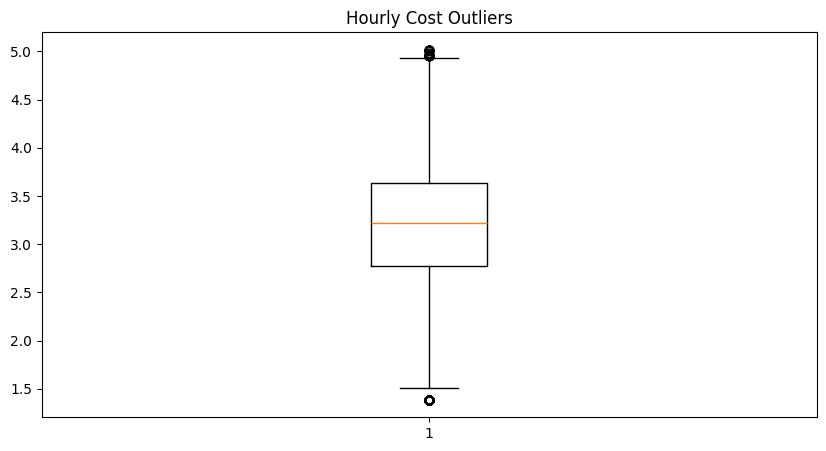

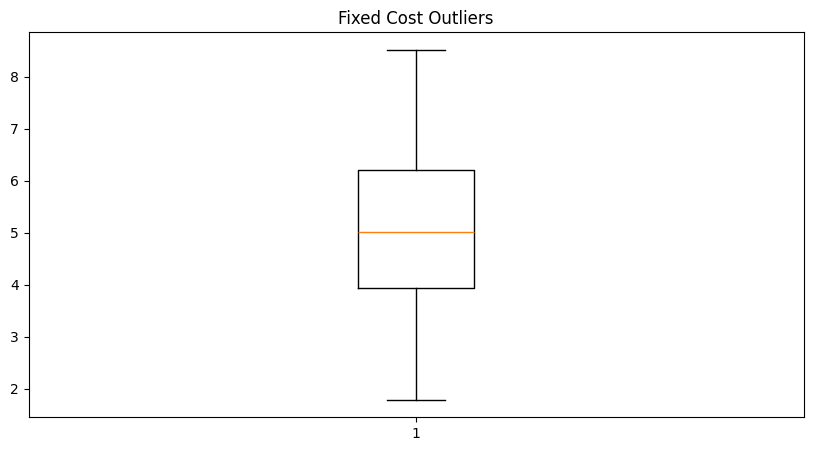

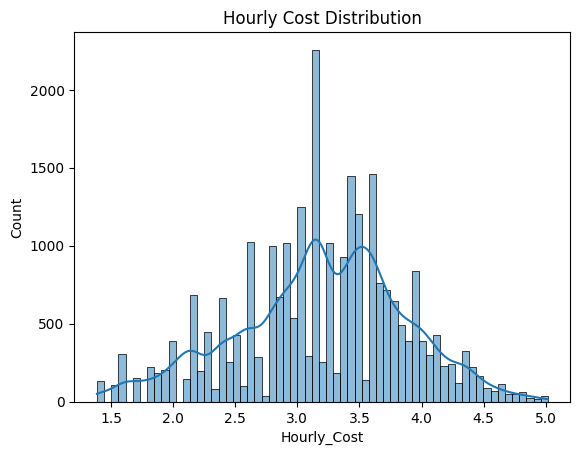

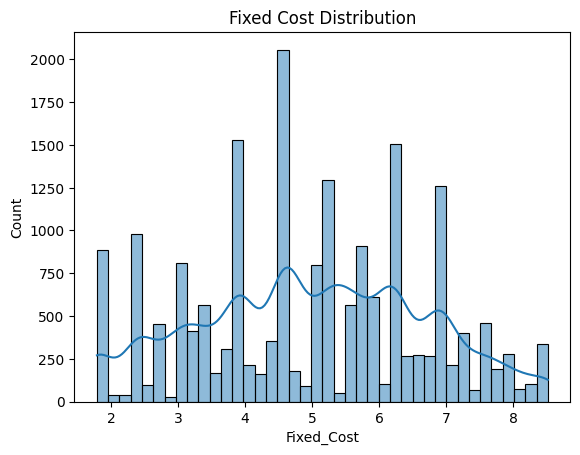

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.boxplot(df['Hourly_Cost'].dropna())
plt.title('Hourly Cost Outliers')
plt.show()

plt.figure(figsize=(10, 5))
plt.boxplot(df['Fixed_Cost'].dropna())
plt.title('Fixed Cost Outliers')
plt.show()

import seaborn as sns

sns.histplot(df['Hourly_Cost'].dropna(), kde=True)
plt.title('Hourly Cost Distribution')
plt.show()

sns.histplot(df['Fixed_Cost'].dropna(), kde=True)
plt.title('Fixed Cost Distribution')
plt.show()

In [21]:
# Drop unnecessary columns
features = df.drop(columns=['Job_Cost', 'Hourly_Rate','Hourly_Cost', 'Fixed_Cost'])


# Split technologies into separate binary features
category_3_encoded = df['Category 3'].str.get_dummies(sep=', ')

# Combine with other features
features = pd.concat([features, category_3_encoded], axis=1)

# Drop original Category 3 column
features.drop(columns=['Category 3'], inplace=True)

KeyError: 'Category 3'

In [55]:
# Convert categorical features to dummy variables
#features = pd.get_dummies(features)
# Separate hourly and fixed datasets
hourly_features = df[df['Payment_type_Hourly'] == 1]
hourly_target = df['Hourly_Cost'].dropna()

fixed_features = df[df['Payment_type_Hourly'] == 0]
fixed_target = df['Fixed_Cost'].dropna()

#features = features.drop(columns=['Payment_type_Hourly'])

In [56]:
# Separate hourly and fixed datasets
hourly_features = df[df['Payment_type_Hourly'] == 1]
hourly_target = df.loc[df['Payment_type_Hourly'] == 1, 'Hourly_Cost']

fixed_features = df[df['Payment_type_Hourly'] == 0]
fixed_target = df.loc[df['Payment_type_Hourly'] == 0, 'Fixed_Cost']

# Drop unnecessary columns
fixed_features = fixed_features.drop(columns=['Job_Cost', 'Hourly_Rate','Hourly_Cost', 'Fixed_Cost','Payment_type_Hourly'])

hourly_features = hourly_features.drop(columns=['Job_Cost', 'Hourly_Rate','Hourly_Cost', 'Fixed_Cost','Payment_type_Hourly'])

In [57]:
hourly_features

Payment_Situation_Payment verified  EX_level_demand      Spent  \
2                                       1                2   5.303305   
3                                       1                1  11.512935   
4                                       1                1  11.512935   
6                                       1                2   0.000000   
7                                       0                2   0.000000   
...                                   ...              ...        ...   
46511                                   1                2  11.512935   
46512                                   1                2   9.210440   
46513                                   1                1   0.000000   
46514                                   1                1  10.308986   
46515                                   1                1   9.210440   

       Connects  Feedback_Num  Applicants_Num  \
2            12      0.693147               3   
3            12      3.295837               3   
4            12      2.484907               3   
6            12      0.000000               3   
7             4      0.000000               3   
...         ...           ...             ...   
46511        12      5.971262               8   
46512        12      3.178054              13   
46513        12      0.000000              35   
46514        12      4.290459              13   
46515        12      1.609438               8   

                                  Category Client_Country  
2           Data Science & SQL Development  United States  
3                 DevOps & Cloud Platforms         Canada  
4        Machine Learning & AI Development  United States  
6           Data Science & SQL Development         Poland  
7            Big Data & Business Analytics        Bolivia  
...                                    ...            ...  
46511               Content Creation & SEO  United States  
46512               Content Creation & SEO  United States  
46513  Influencer & Social Media Marketing  United States  
46514     Digital & Social Media Marketing  United States  
46515           Web & Branding Development         Poland  

[26437 rows x 8 columns]

In [58]:
# Split hourly data
X_hourly_train, X_hourly_test, y_hourly_train, y_hourly_test = train_test_split(
    hourly_features, hourly_target, test_size=0.2, random_state=42
)

# Split fixed data
X_fixed_train, X_fixed_test, y_fixed_train, y_fixed_test = train_test_split(
    fixed_features, fixed_target, test_size=0.2, random_state=42
)


In [59]:
hourly_features

Payment_Situation_Payment verified  EX_level_demand      Spent  \
2                                       1                2   5.303305   
3                                       1                1  11.512935   
4                                       1                1  11.512935   
6                                       1                2   0.000000   
7                                       0                2   0.000000   
...                                   ...              ...        ...   
46511                                   1                2  11.512935   
46512                                   1                2   9.210440   
46513                                   1                1   0.000000   
46514                                   1                1  10.308986   
46515                                   1                1   9.210440   

       Connects  Feedback_Num  Applicants_Num  \
2            12      0.693147               3   
3            12      3.295837               3   
4            12      2.484907               3   
6            12      0.000000               3   
7             4      0.000000               3   
...         ...           ...             ...   
46511        12      5.971262               8   
46512        12      3.178054              13   
46513        12      0.000000              35   
46514        12      4.290459              13   
46515        12      1.609438               8   

                                  Category Client_Country  
2           Data Science & SQL Development  United States  
3                 DevOps & Cloud Platforms         Canada  
4        Machine Learning & AI Development  United States  
6           Data Science & SQL Development         Poland  
7            Big Data & Business Analytics        Bolivia  
...                                    ...            ...  
46511               Content Creation & SEO  United States  
46512               Content Creation & SEO  United States  
46513  Influencer & Social Media Marketing  United States  
46514     Digital & Social Media Marketing  United States  
46515           Web & Branding Development         Poland  

[26437 rows x 8 columns]

In [60]:
# Initialize CatBoost models
hourly_model = CatBoostRegressor(cat_features=['Category','Client_Country'])
fixed_model = CatBoostRegressor(cat_features=['Category','Client_Country'])


# Remove special characters from column names
X_hourly_train.columns = X_hourly_train.columns.str.replace(r"[\[\]<]", "", regex=True)
X_hourly_test.columns = X_hourly_test.columns.str.replace(r"[\[\]<]", "", regex=True)

X_fixed_train.columns = X_fixed_train.columns.str.replace(r"[\[\]<]", "", regex=True)
X_fixed_test.columns = X_fixed_test.columns.str.replace(r"[\[\]<]", "", regex=True)

In [61]:
# Train hourly model
hourly_model.fit(X_hourly_train, y_hourly_train)

# Train fixed model
fixed_model.fit(X_fixed_train, y_fixed_train)

Learning rate set to 0.066309
0:	learn: 20.5343522	total: 8.33ms	remaining: 8.32s
1:	learn: 20.3992748	total: 15.2ms	remaining: 7.57s
2:	learn: 20.2743089	total: 20.6ms	remaining: 6.83s
3:	learn: 20.1683886	total: 26.5ms	remaining: 6.6s
4:	learn: 20.0790426	total: 31.1ms	remaining: 6.2s
5:	learn: 19.9891979	total: 38.2ms	remaining: 6.32s
6:	learn: 19.9098087	total: 43.9ms	remaining: 6.22s
7:	learn: 19.8394124	total: 47.8ms	remaining: 5.92s
8:	learn: 19.7809549	total: 53.8ms	remaining: 5.92s
9:	learn: 19.7254676	total: 59.4ms	remaining: 5.88s
10:	learn: 19.6760939	total: 69.4ms	remaining: 6.24s
11:	learn: 19.6305936	total: 77.4ms	remaining: 6.37s
12:	learn: 19.5875644	total: 84.5ms	remaining: 6.41s
13:	learn: 19.5534136	total: 95.6ms	remaining: 6.73s
14:	learn: 19.5228989	total: 110ms	remaining: 7.25s
15:	learn: 19.4980565	total: 118ms	remaining: 7.26s
16:	learn: 19.4667135	total: 122ms	remaining: 7.08s
17:	learn: 19.4480537	total: 127ms	remaining: 6.91s
18:	learn: 19.4216592	total: 131

In [62]:
# Feature Importance
hourly_importance = pd.DataFrame({
    'Feature': X_hourly_train.columns,
    'Importance': hourly_model.get_feature_importance()
}).sort_values(by='Importance', ascending=False)
print("Hourly Model Feature Importance:")
print(hourly_importance)

Hourly Model Feature Importance:
                              Feature  Importance
6                            Category   22.477282
7                      Client_Country   20.304716
1                     EX_level_demand   15.346661
4                        Feedback_Num   12.712170
2                               Spent   11.519098
5                      Applicants_Num    8.646041
3                            Connects    6.407740
0  Payment_Situation_Payment verified    2.586291


In [65]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score
import numpy as np

def evaluate(y_test, predictions, normalization='range'):
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    medae = median_absolute_error(y_test, predictions)  # Calculate MedAE
    r2 = r2_score(y_test, predictions)
    rmse = np.sqrt(mse)  # Calculate RMSE
    
    if normalization == 'range':
        # NRMSE using range
        nrmse = rmse / (y_test.max() - y_test.min())
    elif normalization == 'mean':
        # NRMSE using mean
        nrmse = rmse / y_test.mean()
    else:
        raise ValueError("Invalid normalization method. Use 'range' or 'mean'.")
    
    return mse, mae, medae, r2, rmse, nrmse

# Evaluate hourly model
hourly_metrics = evaluate(y_hourly_test, hourly_preds, normalization='range')
print(f"Hourly Model - MSE: {hourly_metrics[0]}, MAE: {hourly_metrics[1]}, MedAE: {hourly_metrics[2]}, R2: {hourly_metrics[3]}, RMSE: {hourly_metrics[4]}, NRMSE: {hourly_metrics[5]}")

# Evaluate fixed model
fixed_metrics = evaluate(y_fixed_test, fixed_preds, normalization='range')
print(f"Fixed Model - MSE: {fixed_metrics[0]}, MAE: {fixed_metrics[1]}, MedAE: {fixed_metrics[2]}, R2: {fixed_metrics[3]}, RMSE: {fixed_metrics[4]}, NRMSE: {fixed_metrics[5]}")


Hourly Model - MSE: 351.59379925290875, MAE: 13.435757996070466, MedAE: 10.19521346963774, R2: 0.17267808009030206, RMSE: 18.75083462816812, NRMSE: 0.12755669815080353
Fixed Model - MSE: 477673.80686036684, MAE: 363.2040611706292, MedAE: 158.57204157470414, R2: 0.38793737139825035, RMSE: 691.1394988425758, NRMSE: 0.1383662660345497


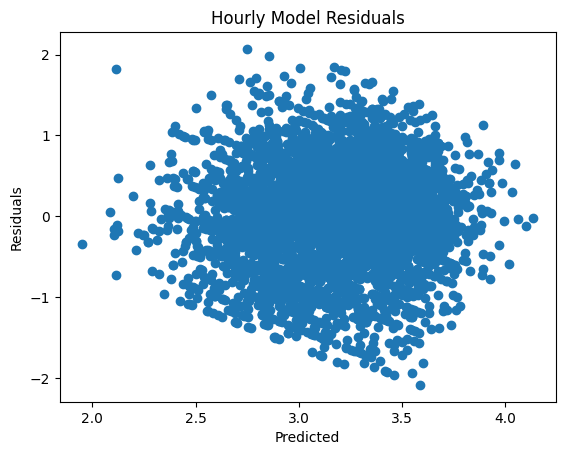

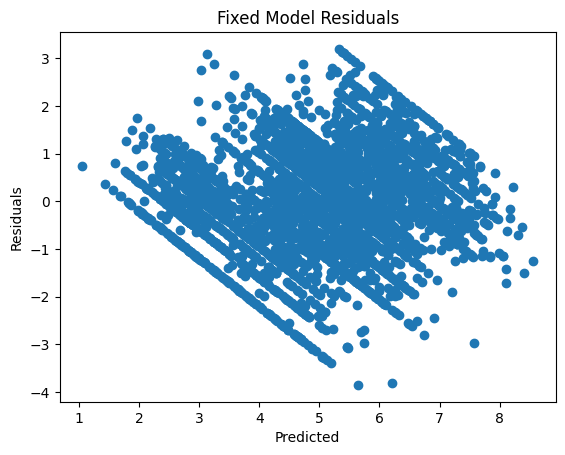

In [12]:
# Residuals for hourly model (original scale)
plt.scatter(np.expm1(hourly_preds), np.expm1(y_hourly_test) - np.expm1(hourly_preds))
plt.title('Hourly Model Residuals (Original Scale)')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.show()

# Residuals for fixed model (original scale)
plt.scatter(np.expm1(fixed_preds), np.expm1(y_fixed_test) - np.expm1(fixed_preds))
plt.title('Fixed Model Residuals (Original Scale)')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.show()


In [13]:
X_hourly_train = X_hourly_train.astype({col: 'int64' for col in X_hourly_train.select_dtypes('bool').columns})
X_hourly_test = X_hourly_test.astype({col: 'int64' for col in X_hourly_test.select_dtypes('bool').columns})

X_fixed_train = X_fixed_train.astype({col: 'int64' for col in X_fixed_train.select_dtypes('bool').columns})
X_fixed_test = X_fixed_test.astype({col: 'int64' for col in X_fixed_test.select_dtypes('bool').columns})


100%|===================| 5270/5288 [01:15<00:00]        

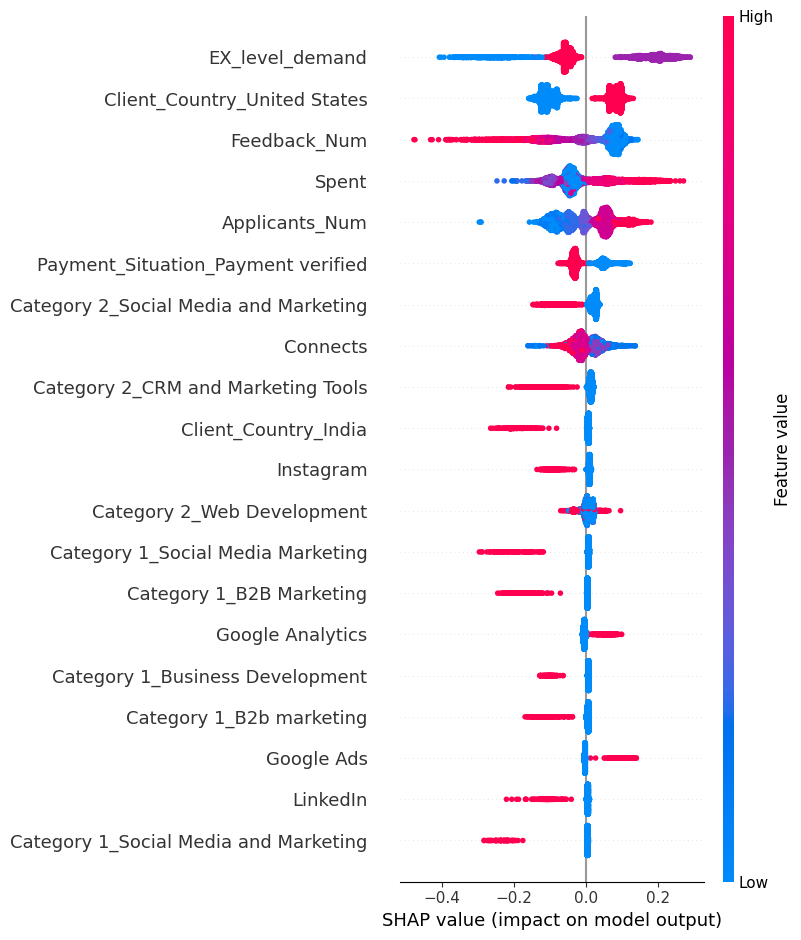

 99%|===================| 3823/3875 [00:52<00:00]        

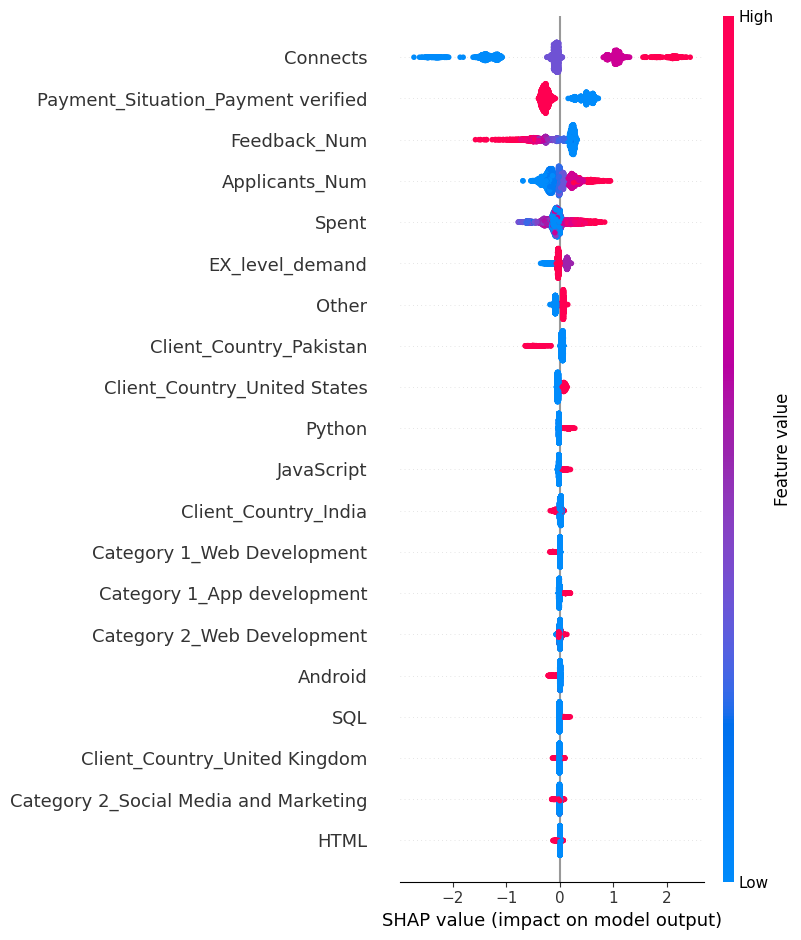

In [14]:
# SHAP for hourly model
explainer_hourly = shap.Explainer(hourly_model, X_hourly_train)
shap_values_hourly = explainer_hourly(X_hourly_test)

# SHAP summary plot
shap.summary_plot(shap_values_hourly, X_hourly_test)

# SHAP for fixed model
explainer_fixed = shap.Explainer(fixed_model, X_fixed_train)
shap_values_fixed = explainer_fixed(X_fixed_test)

# SHAP summary plot
shap.summary_plot(shap_values_fixed, X_fixed_test)


In [15]:
# LIME for hourly model
lime_explainer_hourly = lime.lime_tabular.LimeTabularExplainer(
    X_hourly_train.values, feature_names=X_hourly_train.columns, mode='regression'
)
lime_exp_hourly = lime_explainer_hourly.explain_instance(
    X_hourly_test.iloc[0].values, hourly_model.predict
)
lime_exp_hourly.show_in_notebook()

# LIME for fixed model
lime_explainer_fixed = lime.lime_tabular.LimeTabularExplainer(
    X_fixed_train.values, feature_names=X_fixed_train.columns, mode='regression'
)
lime_exp_fixed = lime_explainer_fixed.explain_instance(
    X_fixed_test.iloc[0].values, fixed_model.predict
)
lime_exp_fixed.show_in_notebook()
